In [355]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For tesxt:
import re

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Read in Data

In [21]:
lstn = pd.read_csv('../data/prepped_training.csv')

In [145]:
validation = pd.read_csv('../data/prepped_validation.csv')

In [93]:
# The code below will aggregate the correlation coefficients between all columns which are not
#  price and log_price vs. price and log price

# This code using dictionaries was written with the help of the following sourece:
#  https://www.guru99.com/python-dictionary-append.html
corr_dict = {'name': [], 'price_corr':[], 'log_price_corr': [], 'magnitude': [], 'which': []}

# Get a list of all the columns to iterate through, remvoe price and log_price
col_list = list(lstn.columns)
col_list.remove('price')
col_list.remove('log_price')

# This loop creates data for each column
for col in col_list:
    
    # Find correlations to price and log_price
    p_corr = np.corrcoef(lstn[col], lstn['price'])[0][1]
    lp_corr = np.corrcoef(lstn[col], lstn['log_price'])[0][1]
    
    # Repor the higher magnitude value
    mag = max(abs(p_corr), abs(lp_corr))
    
    # Append the above data to the dictionary
    corr_dict['name'].append(col)
    corr_dict['price_corr'].append(p_corr)
    corr_dict['log_price_corr'].append(lp_corr)
    corr_dict['magnitude'].append(mag)
    
    # The if statement below will print which correaltion is stronger
    if abs(p_corr) > abs(lp_corr):
        corr_dict['which'].append('price')
    
    else:
        corr_dict['which'].append('log_price')

# Create a dataframe from the dictionary
corr_df = pd.DataFrame(corr_dict)

# Set the index to be the column names collected as there is no need for a numerical index
corr_df.set_index('name', inplace=True)
corr_df.head()

,price_corr,log_price_corr,magnitude,which
name,,,,
host_since,0.039550,0.027396,0.039550,price
host_response_rate,-0.003495,0.041759,0.041759,log_price
host_acceptance_rate,0.130797,0.271477,0.271477,log_price
host_listings_count,0.016601,0.136672,0.136672,log_price
host_total_listings_count,-0.011012,0.082024,0.082024,log_price


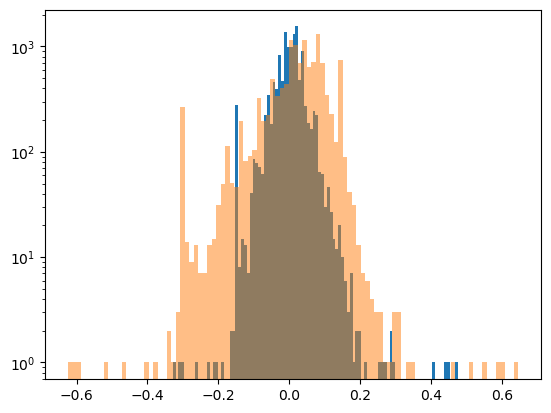

In [94]:
# Plot an overlapping histogram of the correlation distributions
plt.hist(corr_df.price_corr, bins = 100)
plt.hist(corr_df.log_price_corr, bins = 100, alpha = 0.5)
plt.yscale('log')
plt.show();

In [99]:
# Create a dataframe sorted by the correlation magnitude
corr_df_sorted = corr_df.sort_values(by = 'magnitude', ascending=False)

# Create an empty list to store the column names
best_columns = []

# Create an index to loop through
bc_index = 0

# Write a while loop to get the top 30 most highly correlated columns which are
#  not already duplicated in the list with either their log or non-log counterparts
while len(best_columns) < 30:
    
    # simplify the name of the individual column names pulled out of the df index
    next_column = corr_df_sorted.index[bc_index]
    
    # If the log version not is already there, and if the non-log version of the colunm
    #  name are not already there, then add the column name
    if f'log_{next_column}' not in best_columns and next_column.replace('log_', '') not in best_columns:
        best_columns.append(next_column)
    
    # Increase the index value by 1
    bc_index += 1

In [100]:
# View the most highly correlated variables above in the correlation dataframe
corr_df_sorted.loc[best_columns]

,price_corr,log_price_corr,magnitude,which
name,,,,
log_accommodates,0.437727,0.647343,0.647343,log_price
room_type_Private room,-0.328703,-0.625225,0.625225,log_price
pcnt_private,-0.310895,-0.605388,0.605388,log_price
pcnt_ent_homes,0.292924,0.598974,0.598974,log_price
property_type_Private room in rental unit,-0.258554,-0.519602,0.519602,log_price
log_beds,0.405373,0.516437,0.516437,log_price
log_calculated_host_listings_count_private_rooms,-0.226114,-0.462623,0.462623,log_price
bathrooms_text_1 shared bath,-0.207068,-0.397327,0.397327,log_price
amen_Lock on bedroom door,-0.208319,-0.381361,0.381361,log_price


In [103]:
# Filter the original training data with only the columns above:
lstn_best = lstn[best_columns]

# Append the log_price column
lstn_best['log_price'] = lstn.log_price

lstn_best.head()

C:\Users\Dan\AppData\Local\Temp\ipykernel_18932\2672393132.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstn_best['log_price'] = lstn.log_price


,log_accommodates,room_type_Private room,pcnt_private,pcnt_ent_homes,property_type_Private room in rental unit,log_beds,log_calculated_host_listings_count_private_rooms,bathrooms_text_1 shared bath,amen_Lock on bedroom door,description_shared,...,host_about_experience of,log_bedrooms,description_space br about,description_the space br about,description_this home br br,description_space br about this,description_about this home br,description_br about this home,host_about_to rent,log_price
0,1.609438,0.0,0.000,1.000,0.0,0.693147,0.000000,0.0,0,0,...,0,0.693147,0,0,0,0,0,0,0,5.484797
1,1.386294,0.0,0.000,1.000,0.0,0.693147,0.000000,0.0,0,1,...,0,0.000000,0,0,0,0,0,0,0,5.669881
2,0.000000,1.0,1.000,0.000,1.0,0.000000,3.433987,0.0,1,1,...,0,0.000000,0,0,0,0,0,0,0,3.583519
3,0.693147,1.0,0.982,0.018,1.0,0.000000,5.613128,0.0,0,1,...,1,1.386294,1,1,1,1,1,1,1,4.290459
4,2.772589,0.0,0.000,1.000,0.0,1.609438,0.000000,0.0,0,0,...,0,1.386294,0,0,0,0,0,0,0,6.656727


<Axes: >

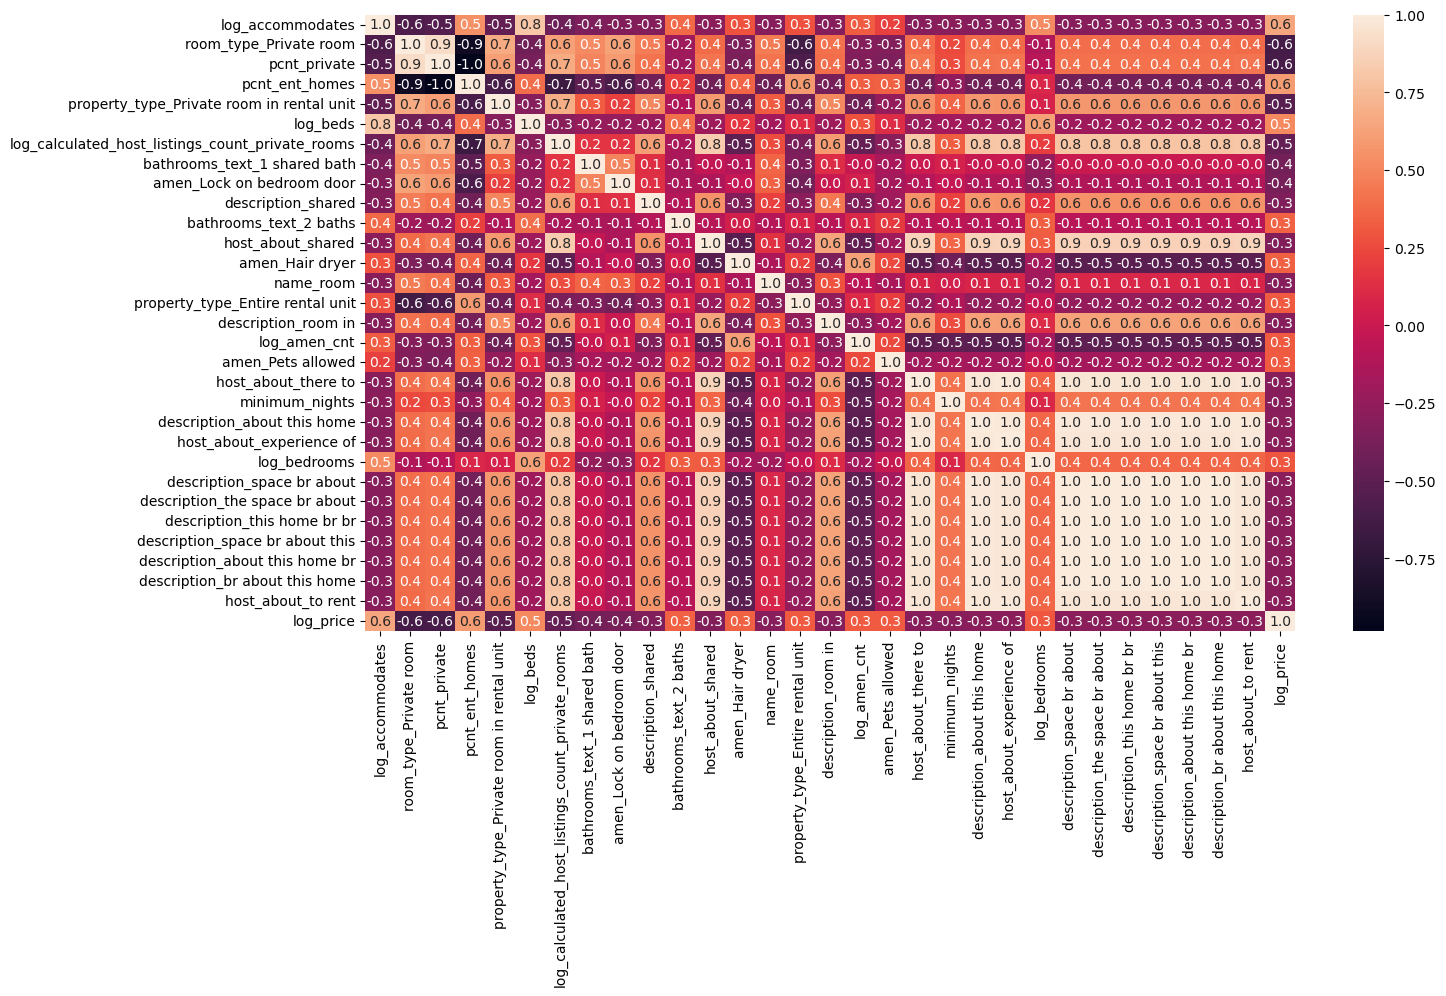

In [111]:
plt.figure(figsize = (15, 8))
sns.heatmap(lstn_best.corr(), annot = True, fmt='.1f')

In [229]:
best_cols_no_mc = [best_columns[0]]

for col in best_columns:
    # print(best_cols_no_mc)
    # print(col)
    corrcoefs = []
    
    for col_no_mc in best_cols_no_mc:
        #print(col_no_mc)
        corr_mc = np.corrcoef(lstn[col], lstn[col_no_mc])[0][1]
        corrcoefs.append(abs(corr_mc))
        #print(f'{col} vs. {col_no_mc}: {corr_mc}')
    
    if max(corrcoefs) < 0.7:
        best_cols_no_mc.append(col)
        #print('yes!\n')
    
    #else:
        #print('no!\n')

In [232]:
best_cols_no_mc_copy = best_cols_no_mc.copy()
best_cols_no_mc_copy.append('log_price')

<Axes: >

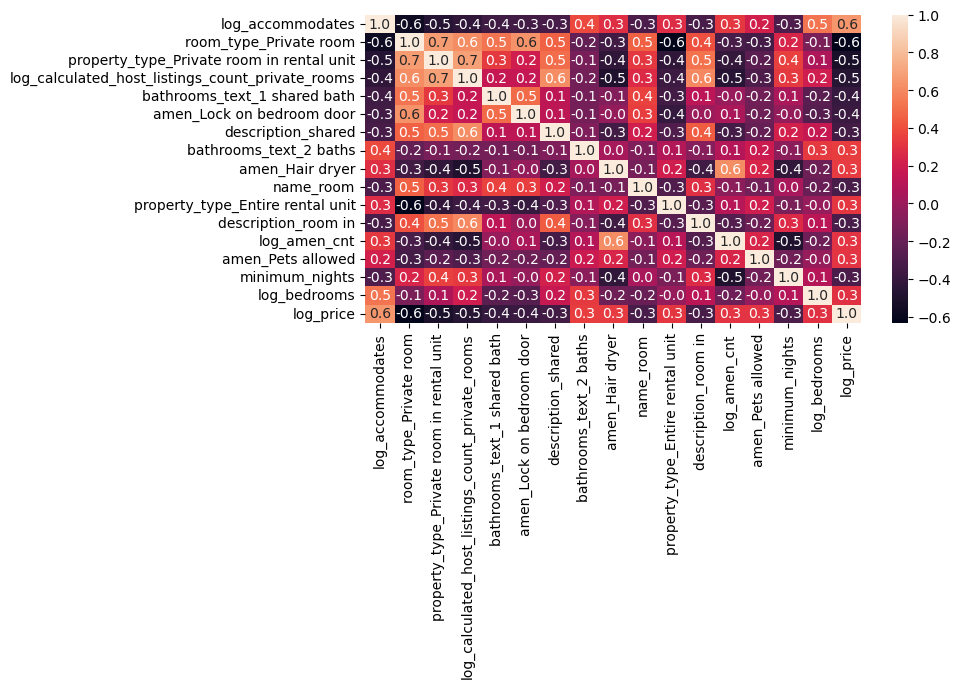

In [234]:
plt.figure(figsize = (8, 4))
sns.heatmap(lstn[best_cols_no_mc_copy].corr(), annot = True, fmt='.1f')

In [148]:
validation['log_price']

0      5.351858
1      5.459586
2      5.293305
3      5.181784
4      3.583519
         ...   
691    4.394449
692    6.354370
693    6.327937
694    6.536692
695    5.420535
Name: log_price, Length: 696, dtype: float64

# Build a Basic Linear Regression Model

In [155]:
X_train, y_train = lstn_best[best_cols_no_mc].drop(columns = 'log_price'), lstn_best[best_cols_no_mc]['log_price']
X_val, y_val = validation[best_cols_no_mc].drop(columns = 'log_price'), validation['log_price']

In [212]:
lr = LinearRegression()

lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_val, y_val)

(0.5651106876838519, 0.5528688076929335)

In [256]:
r2_score(lstn['price'], np.exp(lr.predict(X_train_best_cols_no_mc)))

0.2236900979956813

In [257]:
r2_score(validation['price'], np.exp(lr.predict(X_val)))

0.040581432848077914

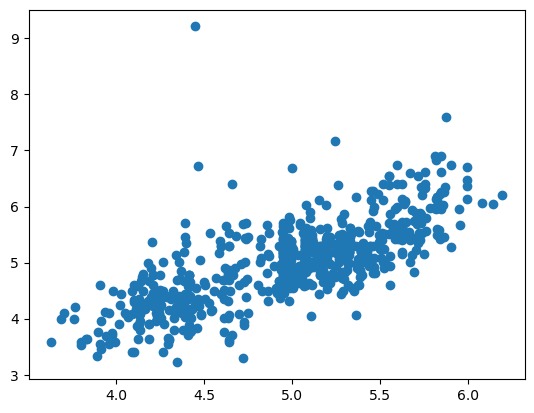

In [305]:
plt.scatter((lr.predict(X_val)), validation['log_price']);

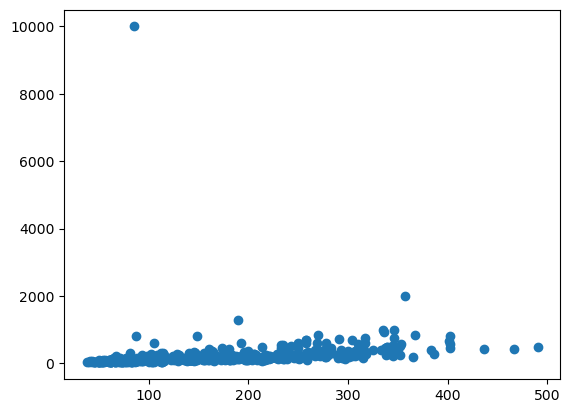

(0.0, 1000.0)

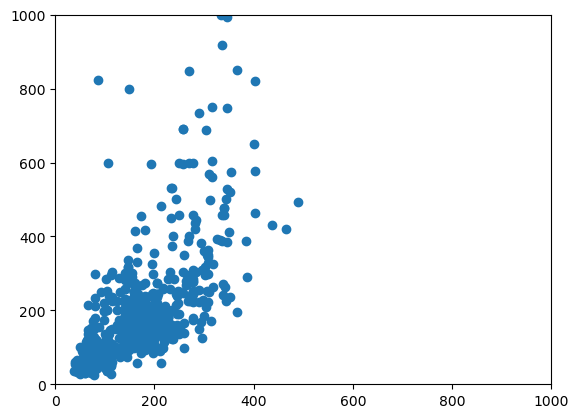

In [176]:
plt.scatter(np.exp(lr.predict(X_val)), validation['price'])
plt.show()

plt.scatter(np.exp(lr.predict(X_val)), validation['price'])
plt.ylim(0, 1000)
plt.xlim(0, 1000)

# Automate Modeling Process

In [370]:
'''
Create a function that will create training and validation datasets based on a list of
input columns against price and log_price data.  Do this only for the X data, y will 
always be the same.
'''

def data_X_maker(data_train, data_val, col_list, col_list_name):
    globals()[f'X_train_{col_list_name}']  = data_train[best_cols_no_mc]
    #print(f'X_train_{col_list_name}')
    
    globals()[f'X_val_{col_list_name}'] = data_val[best_cols_no_mc]
    #print(f'X_val_{col_list_name}')
    
    # Create common y datasets:
    globals()[f'y_train_{col_list_name}'] = data_train['price']
    #print(f'y_train_{col_list_name}')
    
    globals()[f'y_val_{col_list_name}'] = data_val['price']
    #print(f'y_val_{col_list_name}')
    
    globals()[f'y_train_log_{col_list_name}'] = data_train['log_price']
    #print(f'y_train_log_{col_list_name}')
    
    globals()[f'y_val_log_{col_list_name}'] = data_val['log_price']
    #print(f'y_val_log_{col_list_name}')
    
    globals()[f'data_list_{col_list_name}'] = [
        globals()[f'X_train_{col_list_name}'],
        globals()[f'X_val_{col_list_name}'],
        globals()[f'y_train_{col_list_name}'],
        globals()[f'y_val_{col_list_name}'],
        globals()[f'y_train_log_{col_list_name}'],
        globals()[f'y_val_log_{col_list_name}']
    ]
    print(f'data_list_{col_list_name}')
    
    return globals()[f'data_list_{col_list_name}']

def model_maker(data_list, col_list_name, mod_list):
    
    # Import data from a data list grabbing each component by index
    # X Data
    X_train_df = data_list[0]
    X_val_df = data_list[1]
    
    # y datasets:
    y_train = data_list[2]
    y_val = data_list[3]
    
    y_train_log = data_list[4]
    y_val_log = data_list[5]

    
    color_code = 0
    
    for model in mod_list:
        
        # **************  PRICE MODEL  ****************************************
        # Run Models on price
        model_inst = model
        model_inst.fit(X_train_df, y_train)
        
        # Scores      
        preds_price_train = model_inst.predict(X_train_df)
        preds_price_val = model_inst.predict(X_val_df)
        
        r2_train_price = round(model_inst.score(X_train_df, y_train), 3)
        r2_val_price = round(r2_score(y_val, preds_price_val), 3)
        
        #r2_val_log_price = round(r2_score(y_val, preds_log_price_val), 3)
        
        
        rmse_train_price = round(mean_squared_error(y_train, preds_price_train, squared = False), 3)
        rmse_val_price = round(mean_squared_error(y_val, preds_price_val, squared = False), 3)
        
        
        # ***************  LOG PRICE MODEL  ***************************************
        # Run models on log price
        model_inst_log = model
        model_inst_log.fit(X_train_df, y_train_log)
        
        # Scores
        preds_log_price_train = np.exp(model_inst_log.predict(X_train_df))
        preds_log_price_val = np.exp(model_inst_log.predict(X_val_df))
        
        r2_train_log_price = round(r2_score(y_train, preds_log_price_train), 3)
        r2_val_log_price = round(r2_score(y_val, preds_log_price_val), 3)

        rmse_train_log_price = round(mean_squared_error(y_train, preds_log_price_train, squared = False), 3)
        rmse_val_log_price = round(mean_squared_error(y_val, preds_log_price_val, squared = False), 3)
        
        
        print('\n')
        print('=' * 50)       
        print(f'R2 training, price: {r2_train_price}')
        print(f'R2 training, log_price: {r2_train_log_price}')
        
        print(f'RMSE training, price: {rmse_train_price}')
        print(f'RMSE training, log_price: {rmse_train_log_price}\n')
        
        #print('\n')
        print(f'R2 validation, price: {r2_val_price}')
        print(f'R2 validation, log_price: {r2_val_log_price}')
        
        print(f'RMSE validation, price: {rmse_val_price}')
        print(f'RMSE validation, log_price: {rmse_val_log_price}')
        
        
        print('=' * 50)
                        
        plt.figure(figsize = (10, 8))
        plt.subplots_adjust(hspace=0.55)
        

        plt.subplot(2, 2, 1)
        plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
        plt.scatter(y_train, preds_price_train, color = f'C{color_code}')
        plt.xlabel('True Prices')
        plt.ylabel('Predicted Prices')
        
        plt.subplot(2, 2, 2)
        plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
        plt.scatter(y_train, preds_log_price_train, color = f'C{color_code}')
        plt.xlabel('True Prices')
        plt.ylabel('Predicted Prices')
        
        
        plt.subplot(2, 2, 3)
        plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
        plt.scatter(y_val, preds_price_val, color = f'C{color_code}')
        plt.xlabel('True Prices')        
        plt.ylabel('Predicted Prices')
        
        plt.subplot(2, 2, 4)
        plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
        plt.scatter(y_val, preds_log_price_val, color = f'C{color_code}')
        plt.xlabel('True Prices')
        plt.ylabel('Predicted Prices')
        
        plt.show()
        
        color_code += 1

In [344]:
# Make a list of models to run!
list_of_models = [LinearRegression(), RandomForestRegressor()]

data_list_best_cols_no_mc


R2 training, price: 0.236
R2 training, log_price: 0.224
RMSE training, price: 182.061
RMSE training, log_price: 183.556

R2 validation, price: 0.043
R2 validation, log_price: 0.041
RMSE validation, price: 398.155
RMSE validation, log_price: 398.624


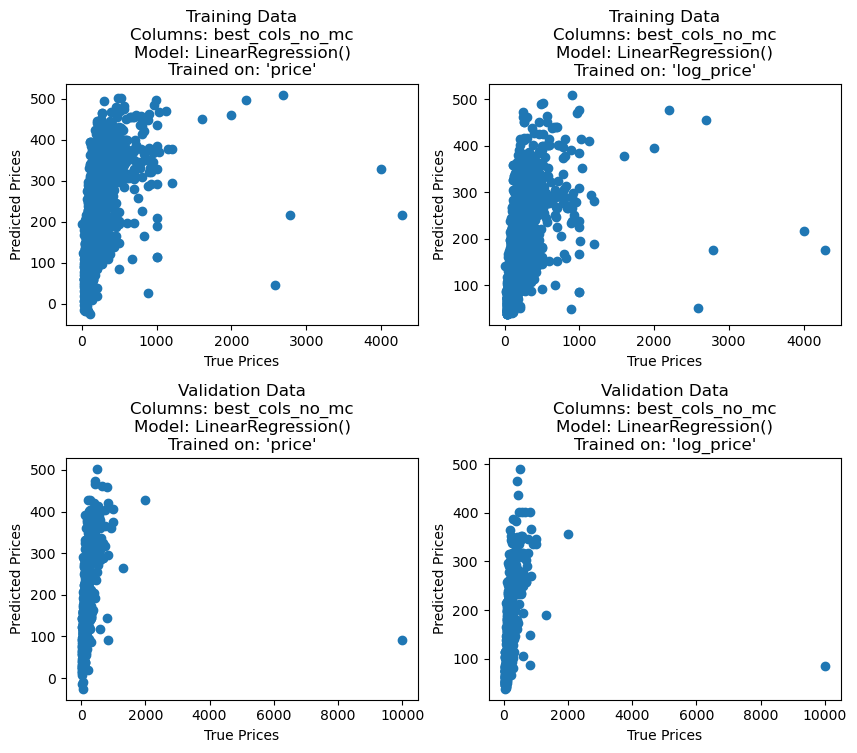



R2 training, price: 0.853
R2 training, log_price: 0.752
RMSE training, price: 79.936
RMSE training, log_price: 103.803

R2 validation, price: 0.064
R2 validation, log_price: 0.056
RMSE validation, price: 393.727
RMSE validation, log_price: 395.48


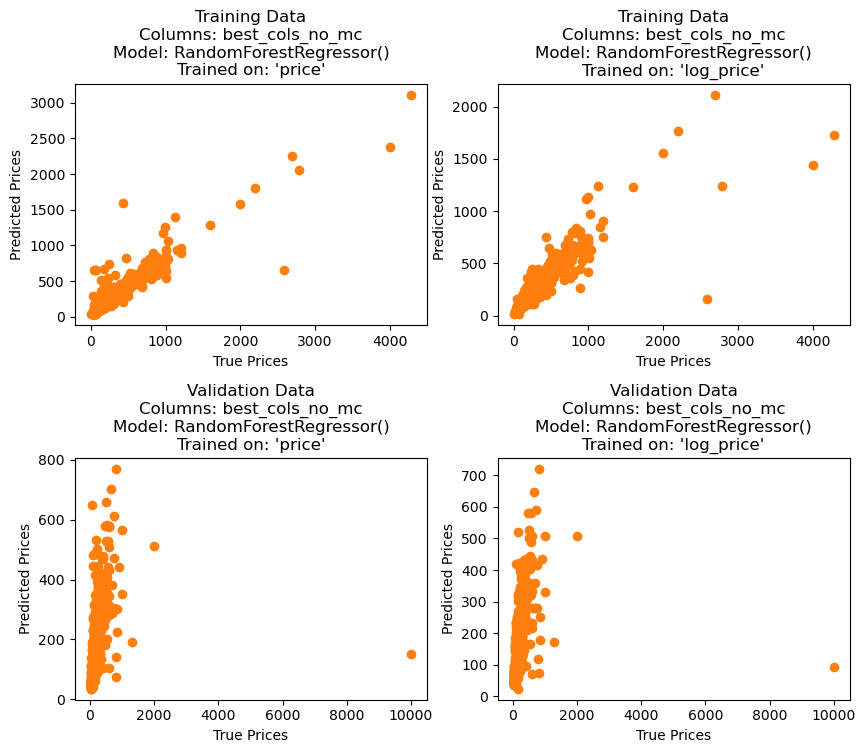

In [371]:
# Run the data maker function inside of the model maker function
model_maker(data_X_maker(lstn, validation, best_cols_no_mc, 'best_cols_no_mc'), 
            'best_cols_no_mc', 
            list_of_models)

#  See what happens when the high-priced listings are filtered out

data_list_best_cols_no_mc


R2 training, price: 0.51
R2 training, log_price: 0.488
RMSE training, price: 48.291
RMSE training, log_price: 49.346

R2 validation, price: 0.496
R2 validation, log_price: 0.454
RMSE validation, price: 49.474
RMSE validation, log_price: 51.522


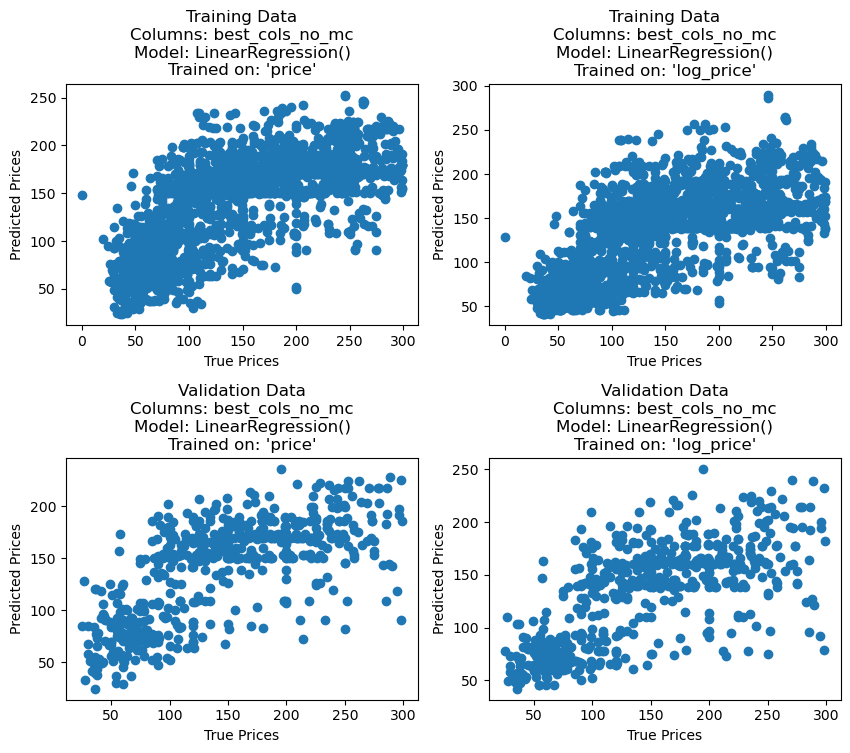



R2 training, price: 0.922
R2 training, log_price: 0.914
RMSE training, price: 19.236
RMSE training, log_price: 20.204

R2 validation, price: 0.58
R2 validation, log_price: 0.574
RMSE validation, price: 45.195
RMSE validation, log_price: 45.511


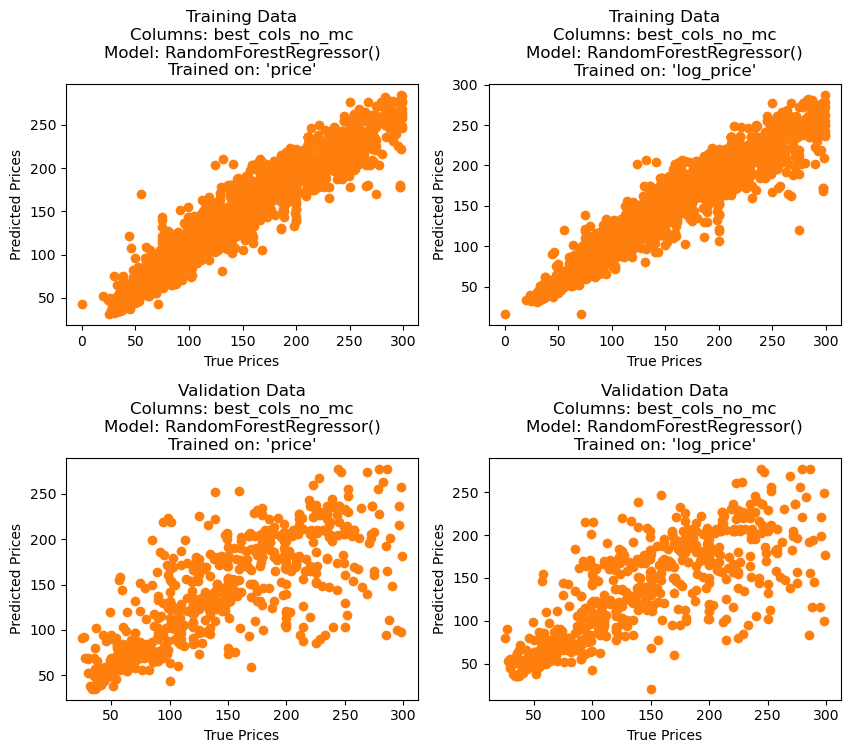

In [372]:
# Run the data maker function inside of the model maker function
model_maker(data_X_maker(lstn[lstn.price < 300], validation[validation.price < 300], best_cols_no_mc, 'best_cols_no_mc'), 
            'best_cols_no_mc', 
            list_of_models)

# JUNK

In [321]:
# '''
# Create a function that will create training and validation datasets based on a list of
# input columns against price and log_price data.  Do this only for the X data, y will 
# always be the same.
# '''

# def data_X_maker(col_list, col_list_name):
#     globals()[f'X_train_{col_list_name}']  = lstn_best[best_cols_no_mc]
#     print(f'X_train_{col_list_name}')
    
#     globals()[f'X_val_{col_list_name}'] = validation[best_cols_no_mc]
#     print(f'X_val_{col_list_name}')

    
    
# def model_maker(X_train_df, X_val_df, col_list_name, mod_list):
    
#     # Create common y datasets:
#     y_train = lstn['price']
#     y_val = validation['price']
    
#     y_train_log = lstn['log_price']
#     y_val_log = validation['log_price']

    
#     color_code = 0
    
#     for model in mod_list:
        
#         # Run Models on price
#         model_inst = model
#         model_inst.fit(X_train_df, y_train)
        
#         # Scores
#         r2_train_price = round(model_inst.score(X_train_df, y_train), 3)
#         r2_val_price = round(model_inst.score(X_val_df, y_val), 3)
        
#         preds_price_train = model_inst.predict(X_train_df)
#         preds_price_val = model_inst.predict(X_val_df)
        
#         # Run models on log price
#         model_inst_log = model
#         model_inst_log.fit(X_train_df, y_train_log)
        
#         # Scores
#         preds_log_price_train = np.exp(model_inst_log.predict(X_train_df))
#         preds_log_price_val = np.exp(model_inst_log.predict(X_val_df))
        
#         r2_train_log_price = round(r2_score(y_train, preds_log_price_train), 3)
#         r2_val_log_price = round(r2_score(y_val, preds_log_price_val), 3)
        
#         print('\n')
#         print('=' * 50)       
#         print(f'R2 training, price: {r2_train_price}')
#         print(f'R2 training, log_price: {r2_train_log_price}\n')
#         #print('\n')
#         print(f'R2 validation, price: {r2_val_price}')
#         print(f'R2 validation, log_price: {r2_val_log_price}')
#         print('=' * 50)
                        
#         plt.figure(figsize = (10, 8))
#         plt.subplots_adjust(hspace=0.55)
        

#         plt.subplot(2, 2, 1)
#         plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
#         plt.scatter(y_train, preds_price_train, color = f'C{color_code}')
#         plt.xlabel('True Prices')
#         plt.ylabel('Predicted Prices')
        
#         plt.subplot(2, 2, 2)
#         plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
#         plt.scatter(y_train, preds_log_price_train, color = f'C{color_code}')
#         plt.xlabel('True Prices')
#         plt.ylabel('Predicted Prices')
        
        
#         plt.subplot(2, 2, 3)
#         plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
#         plt.scatter(y_val, preds_price_val, color = f'C{color_code}')
#         plt.xlabel('True Prices')        
#         plt.ylabel('Predicted Prices')
        
#         plt.subplot(2, 2, 4)
#         plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
#         plt.scatter(y_val, preds_log_price_val, color = f'C{color_code}')
#         plt.xlabel('True Prices')
#         plt.ylabel('Predicted Prices')
        
#         plt.show()
        
#         color_code += 1

In [342]:
# data_X_maker(lstn, validation, best_cols_no_mc, 'best_cols_no_mc');
# model_maker(data_list_best_cols_no_mc, 
#             'best_cols_no_mc', 
#             list_of_models)

# model_maker(X_train_best_cols_no_mc, X_val_best_cols_no_mc, 
#             'best_cols_no_mc', 
#             list_of_models)

In [276]:
# https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
f'{fun=}'.split('=')[0]

'fun'